Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)'],
      dtype='object')
Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）_x', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）_x', '100m风向（°)',
       '出力(MW)', '装机容量(MW)', '站点编号_le', 'time', 'day', 'weekday', 'hour',
       'month', 'minute', 'hour_sin', 'hour_cos', 'time_96',
       '100m风速（100m/s）_y', '10米风速（10m/s）_y', '100m风速（100m/s）', '10米风速（10m/s）'],
      dtype='object')
  站点编号             时间       气压(Pa）  相对湿度（%）        云量  10米风速（10m/s）  10米风向（°)  \
0   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
1   f1  2022-1-3 0:15  102252.0355  74.7530  0.000924        7.7710   23.5766   
2   f1  2022-1-3 0:30  102248.5900  74.4995  0.003009        7.8272   21.5451   
3   f1  2022-1-3 0:45  102240.4725  74.1432  0.011402        7.8637   20.2394   
4   f1  2022-1-3 1:00  102228.8828  73.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

score... 0.04826 rmse...19.72215
score... 0.04831 rmse...19.70137
score... 0.04856 rmse...19.59153
feature importance of lightgbm:
                    name     importance
8         100m风速（100m/s）  118178.669530
3           10米风速（10m/s）   61120.461532
11               站点编号_le    6068.598760
10              装机容量(MW)    4179.587906
26         100m风向（°)_cos    2533.249482
12                   day    1882.974972
62          气压(Pa）_gap96    1859.857764
24          10米风向（°)_cos    1847.830185
7                  降水（m）    1781.255574
5                  温度（K）    1615.702628
9              100m风向（°)    1539.853583
65           降水（m）_gap96    1528.381951
51  100m风速（100m/s）_gap15    1378.508504
23          10米风向（°)_sin    1278.173575
0                 气压(Pa）    1242.384178
20     10米风速（10m/s）_mean    1173.441530
25         100m风向（°)_sin    1170.737833
19   100m风速（100m/s）_mean    1009.069026
57          气压(Pa）_gap50     963.463402
15                 month     919.633630
49    10米风速（10m/s）_gap15     

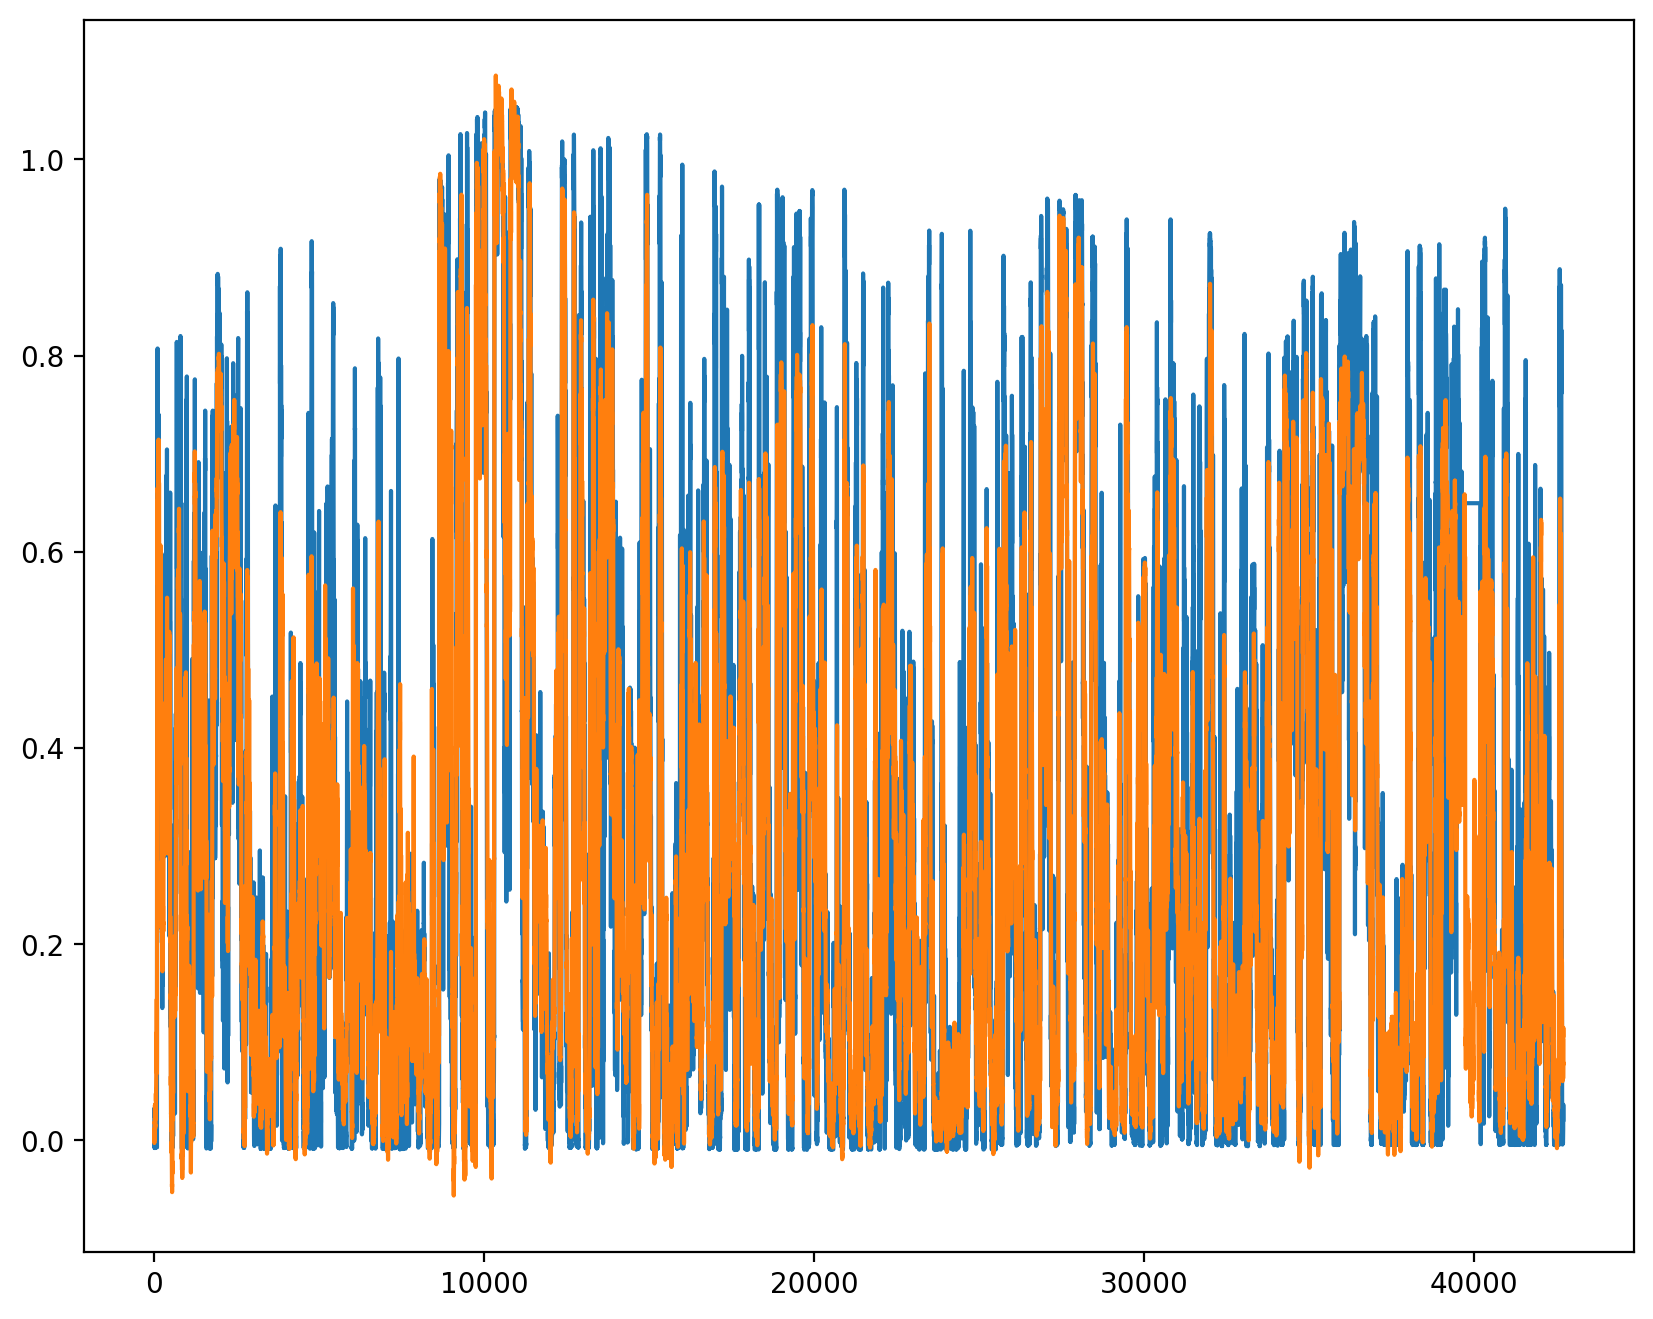

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15016
[LightGBM] [Info] Number of data points in the train set: 231825, number of used features: 67
[LightGBM] [Info] Start training from score 0.314712


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib.pyplot import plot, show, title
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None) 

df_train = pd.read_csv('data/A榜-训练集_海上风电预测_气象变量及实际功率数据.csv', encoding='gbk')
df_test = pd.read_csv('data/A榜-测试集_海上风电预测_气象变量数据.csv', encoding='gbk')

add_df = pd.read_csv('data/A榜-训练集_海上风电预测_基本信息.csv', encoding='gbk')
# add_df = pd.read_csv('df_train/A榜-训练集_海上风电预测_基本信息.csv')
print(df_test.columns)
df = pd.concat([df_train, df_test])
df = df.merge(add_df[['站点编号', '装机容量(MW)']], on='站点编号', how='left')
df['站点编号_le'] = df['站点编号'].map(lambda x: int(x[1]))

df['time'] = pd.to_datetime(df['时间'])
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.weekday
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['minute'] = df['time'].dt.minute

# df['站点编号'] = df['站点编号'].astype('category')
df['hour_sin'] = np.sin(df['hour'] / 23 * 2 * np.pi)
df['hour_cos'] = np.cos(df['hour'] / 23 * 2 * np.pi)
# df['minute_sin'] = np.sin(df['minute'] / 59 * 2 * np.pi)
# df['minute_cos'] = np.cos(df['minute'] / 59 * 2 * np.pi)
df['time_96'] = df.apply(lambda x: (x['hour'] * 60 + x['minute']) / 15 + 1, axis=1)

# df['num_samples'] = list(range(len(df)))


# for col in ['10米风速（10m/s）','100m风速（100m/s）']:
#     df[col+'_squ'] = df[col] ** 2
#     df[col+'_cub'] = df[col] ** 3
#     df[col+'_mean'] = df[col].mean()
#     df[col+'_max'] = df[col].max()
#     df[col+'_min'] = df[col].min()
#     df[col+'_std'] = df[col].std()
#     df[col+'_25'] = df[col].quantile(0.25)
#     df[col+'_50'] = df[col].median()
#     df[col+'_75'] = df[col].quantile(0.75)


df_fs100_mean = df['100m风速（100m/s）'].groupby([df['站点编号'],df['month'],df['hour']]).mean()
df_fs100_std = df['100m风速（100m/s）'].groupby([df['站点编号'],df['month'],df['hour']]).std()
df_fs10_mean = df['10米风速（10m/s）'].groupby([df['站点编号'],df['month'],df['hour']]).mean()
df_fs10_std = df['10米风速（10m/s）'].groupby([df['站点编号'],df['month'],df['hour']]).std()
# print(fs100_mean)
# print(fs10_mean)

merged_df = pd.merge(df, df_fs100_mean, on=['站点编号','month', 'hour'])
merged_df = pd.merge(merged_df, df_fs10_mean, on=['站点编号','month', 'hour'])
merged_df = pd.merge(merged_df, df_fs100_std, on=['站点编号','month', 'hour'])
merged_df = pd.merge(merged_df, df_fs10_std, on=['站点编号','month', 'hour'])
print(merged_df.columns)

# merged_df = merged_df.assign(m100fs_mean=merged_df['100m风速（100m/s）_y'],m10fs_mean=merged_df['10米风速（10m/s）_y'])
# merged_df = merged_df.drop(['100m风速（100m/s）_y', '10米风速（10m/s）_y'], axis=1)
merged_df.rename(columns={'100m风速（100m/s）_x':'100m风速（100m/s）', '10米风速（10m/s）_x':'10米风速（10m/s）',
                          '100m风速（100m/s）_y':'100m风速（100m/s）_mean', '10米风速（10m/s）_y':'10米风速（10m/s）_mean',
                          '100m风速（100m/s）':'100m风速（100m/s）_std', '10米风速（10m/s）':'10米风速（10m/s）_std'}, inplace=True)

merged_df = merged_df.sort_values(by=['站点编号','time'],ascending=[True, True])
df = merged_df.reset_index(drop=True)
print(df[0:5])

for col in ['10米风向（°)', '100m风向（°)']:
    df[col+"_sin"]=df[col].apply(lambda x: np.sin(x/180*np.pi))
    df[col+"_cos"]=df[col].apply(lambda x: np.cos(x/180*np.pi))
    
print(f"gap feature")
gaps=[1,2,4,7,15,30,50,96]
# gaps=[1,2,4,8,16,32,48,96,192,288]
for gap in gaps:
    # for col in ['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)', '温度（K）',
    #        '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)']:
    for col in ['气压(Pa）', '相对湿度（%）', '10米风速（10m/s）', 
            '降水（m）', '100m风速（100m/s）']:
        df[col+f"_shift{gap}"]=df[col].groupby(df['站点编号']).shift(gap, fill_value=0)
        df[col+f"_gap{gap}"]=df[col+f"_shift{gap}"]-df[col]
        df.drop([col+f"_shift{gap}"],axis=1,inplace=True)


# print("one hot encoder")
# for col in ['站点编号']:
#     unique_value=df[col].unique()
#     for value in unique_value:
#         df[col+"_"+str(value)]=(df[col]==value)
#     df.drop([col],axis=1,inplace=True)


LABEL = '出力(MW)'

# df_train = df[df[LABEL].notna()]
# df_test = df[df[LABEL].isna()].reset_index(drop=True)

df_train = df[df['time']< '2023-05-01 0:0:0']
df_test = df[df['time'] >= '2023-05-01 0:0:0']

print(len(df_train))
df_train = df_train[df_train[LABEL]!='<NULL>'].reset_index(drop=True)
df_train[LABEL] = df_train[LABEL].astype('float32')
print(len(df_train))

# 出力归一化
df_train[LABEL] = df_train[LABEL]/df_train['装机容量(MW)']

params_lgb = {
    'learning_rate': 0.03,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'mse',
    'num_leaves': 64,
    'verbose': 1,
    'seed': 13,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
}

params_cb = {
    'learning_rate': 0.03,
    'loss_function': "RMSE",
    'eval_metric': "RMSE",
    'min_data_in_leaf': 64,
    'random_seed': 13,
    'logging_level': 'Silent',
    'use_best_model': True,
    'one_hot_max_size': 5,   #类别数量多于此数将使用ordered target statistics编码方法,默认值为2。
    'boosting_type':"Ordered", #Ordered 或者Plain,数据量较少时建议使用Ordered,训练更慢但能够缓解梯度估计偏差。
    'max_ctr_complexity': 2, #特征组合的最大特征数量，设置为1取消特征组合，设置为2只做两个特征的组合,默认为4。
    'nan_mode': 'Min' 
}



importance = 0
# MODEL_TYPE = 'lgb'

print(df_train.head())


sub_train_df = df_train[df_train['time'] < '2023-02-01 0:0:0']
sub_val_df = df_train[df_train['time'] >= '2023-02-01 0:0:0']


# feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time',  '站点编号', 'min']]
# feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time', '站点编号_le']]
feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time',  '站点编号', 'minute']]
print(feats)

train = lgb.Dataset(sub_train_df[feats],
                    sub_train_df[LABEL])
val = lgb.Dataset(sub_val_df[feats],
                  sub_val_df[LABEL])


model = lgb.train(params_lgb, train, valid_sets=[train, val], num_boost_round=5000, callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])
# model = lgb.train(params_lgb, train, valid_sets=[train, val], num_boost_round=500, categorical_feature=['站点编号'], callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])
model_cat = cb.CatBoostRegressor(iterations=1000,  early_stopping_rounds = 100, **params_cb)
model_cat.fit(sub_train_df[feats], sub_train_df[LABEL], eval_set=(sub_val_df[feats], sub_val_df[LABEL]), verbose=True, plot=True)

val_pred = model.predict(sub_val_df[feats])
val_pred_cat = model_cat.predict(sub_val_df[feats])

s_mse = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred*sub_val_df['装机容量(MW)'], squared=False)
s_mse_cat = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred_cat*sub_val_df['装机容量(MW)'], squared=False)

val_pred_fusion = (val_pred + val_pred_cat)/2
s_mse_fusion = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred_fusion*sub_val_df['装机容量(MW)'], squared=False)

score = 1/(1+s_mse)
print('score... %.5f'%score, 'rmse...%.5f'%s_mse)

score_cat = 1/(1+s_mse_cat)
print('score... %.5f'%score_cat, 'rmse...%.5f'%s_mse_cat)

score_fusion = 1/(1+s_mse_fusion)
print('score... %.5f'%score_fusion, 'rmse...%.5f'%s_mse_fusion)

print('feature importance of lightgbm:')
importance += model.feature_importance(importance_type='gain')
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
print(feats_importance.sort_values('importance', ascending=False)[:30])

print('feature importance of catboost:')
print(model_cat.get_feature_importance(prettified=True)[:30])


plt.figure(figsize=(10,8), dpi=200)
plt.plot(sub_val_df[LABEL].values)
plt.plot(val_pred)
plt.show()

model = lgb.train(params_lgb, lgb.Dataset(df_train[feats], df_train[LABEL]), num_boost_round=model.best_iteration)
# model = lgb.train(params_lgb, lgb.Dataset(df_train[feats], df_train[LABEL]), categorical_feature=['站点编号'], num_boost_round=model.best_iteration)
params_cb['use_best_model'] = False
params_cb['iterations'] = model_cat.get_best_iteration()
model_cat = cb.CatBoostRegressor(**params_cb)
model_cat.fit(df_train[feats], df_train[LABEL], verbose=True, plot=True)

pred_y = model.predict(df_test[feats])

pred_y_cat = model_cat.predict(df_test[feats])
pred_y_fusion = (pred_y+pred_y_cat)/2

# df_test[LABEL] = pred_y*df_test['装机容量(MW)']
df_test[LABEL] = pred_y_fusion*df_test['装机容量(MW)']

# df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score, index=False)
df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score_fusion, index=False)

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib.pyplot import plot, show, title
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None) 
np.random.seed(1234)

df_train = pd.read_csv('data/A榜-训练集_海上风电预测_气象变量及实际功率数据.csv', encoding='gbk')
df_test = pd.read_csv('data/A榜-测试集_海上风电预测_气象变量数据.csv', encoding='gbk')

add_df = pd.read_csv('data/A榜-训练集_海上风电预测_基本信息.csv', encoding='gbk')
# add_df = pd.read_csv('df_train/A榜-训练集_海上风电预测_基本信息.csv')
print(df_test.columns)
df = pd.concat([df_train, df_test])
df = df.merge(add_df[['站点编号', '装机容量(MW)']], on='站点编号', how='left')
df['站点编号_le'] = df['站点编号'].map(lambda x: int(x[1]))

df['time'] = pd.to_datetime(df['时间'])
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.weekday
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['minute'] = df['time'].dt.minute

# df['站点编号'] = df['站点编号'].astype('category')
df['hour_sin'] = np.sin(df['hour'] / 23 * 2 * np.pi)
df['hour_cos'] = np.cos(df['hour'] / 23 * 2 * np.pi)
# df['minute_sin'] = np.sin(df['minute'] / 59 * 2 * np.pi)
# df['minute_cos'] = np.cos(df['minute'] / 59 * 2 * np.pi)
df['time_96'] = df.apply(lambda x: (x['hour'] * 60 + x['minute']) / 15 + 1, axis=1)

# df['num_samples'] = list(range(len(df)))


# for col in ['10米风速（10m/s）','100m风速（100m/s）']:
#     df[col+'_squ'] = df[col] ** 2
#     df[col+'_cub'] = df[col] ** 3
#     df[col+'_mean'] = df[col].mean()
#     df[col+'_max'] = df[col].max()
#     df[col+'_min'] = df[col].min()
#     df[col+'_std'] = df[col].std()
#     df[col+'_25'] = df[col].quantile(0.25)
#     df[col+'_50'] = df[col].median()
#     df[col+'_75'] = df[col].quantile(0.75)


df_fs100_mean = df['100m风速（100m/s）'].groupby([df['站点编号'],df['month'],df['day']]).mean()
df_fs10_mean = df['10米风速（10m/s）'].groupby([df['站点编号'],df['month'],df['day']]).mean()
# print(fs100_mean)
# print(fs10_mean)

merged_df = pd.merge(df, df_fs100_mean, on=['站点编号','month', 'day'])
merged_df = pd.merge(merged_df, df_fs10_mean, on=['站点编号','month', 'day'])

# merged_df = merged_df.assign(m100fs_mean=merged_df['100m风速（100m/s）_y'],m10fs_mean=merged_df['10米风速（10m/s）_y'])
# merged_df = merged_df.drop(['100m风速（100m/s）_y', '10米风速（10m/s）_y'], axis=1)
merged_df.rename(columns={'100m风速（100m/s）_x':'100m风速（100m/s）', '10米风速（10m/s）_x':'10米风速（10m/s）',
                          '100m风速（100m/s）_y':'100m风速（100m/s）_mean', '10米风速（10m/s）_y':'10米风速（10m/s）_mean'}, inplace=True)

merged_df = merged_df.sort_values(by=['站点编号','time'],ascending=[True, True])
df = merged_df.reset_index(drop=True)
print(df[0:5])

for col in ['10米风向（°)', '100m风向（°)']:
    df[col+"_sin"]=df[col].apply(lambda x: np.sin(x/180*np.pi))
    df[col+"_cos"]=df[col].apply(lambda x: np.cos(x/180*np.pi))
    
print(f"gap feature")
gaps=[1,2,4,7,15,30,50,80]
# gaps=[1,2,4,8,16,32,48,96,192,288]
for gap in gaps:
    for col in ['10米风速（10m/s）', 
        '100m风速（100m/s）']:
        df[col+f"_shift{gap}"]=df[col].groupby(df['站点编号']).shift(gap, fill_value=0)
        df[col+f"_gap{gap}"]=df[col+f"_shift{gap}"]-df[col]
        df.drop([col+f"_shift{gap}"],axis=1,inplace=True)


# print("one hot encoder")
# for col in ['站点编号']:
#     unique_value=df[col].unique()
#     for value in unique_value:
#         df[col+"_"+str(value)]=(df[col]==value)
#     df.drop([col],axis=1,inplace=True)


LABEL = '出力(MW)'

# df_train = df[df[LABEL].notna()]
# df_test = df[df[LABEL].isna()].reset_index(drop=True)

df_train = df[df['time']< '2023-05-01 0:0:0']
df_test = df[df['time'] >= '2023-05-01 0:0:0']

print(len(df_train))
df_train = df_train[df_train[LABEL]!='<NULL>'].reset_index(drop=True)
df_train[LABEL] = df_train[LABEL].astype('float32')
print(len(df_train))

# 出力归一化
df_train[LABEL] = df_train[LABEL]/df_train['装机容量(MW)']

params_lgb = {
    'learning_rate': 0.03,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'mse',
    'num_leaves': 64,
    'verbose': 1,
    'seed': 13,
    'n_jobs': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
}

params_cb = {
    'learning_rate': 0.03,
    'loss_function': "RMSE",
    'eval_metric': "RMSE",
    'min_data_in_leaf': 64,
    'random_seed': 13,
    'logging_level': 'Silent',
    'use_best_model': True,
    'one_hot_max_size': 5,   #类别数量多于此数将使用ordered target statistics编码方法,默认值为2。
    'boosting_type':"Ordered", #Ordered 或者Plain,数据量较少时建议使用Ordered,训练更慢但能够缓解梯度估计偏差。
    'max_ctr_complexity': 2, #特征组合的最大特征数量，设置为1取消特征组合，设置为2只做两个特征的组合,默认为4。
    'nan_mode': 'Min' 
}

importance = 0
# MODEL_TYPE = 'lgb'

print(df_train.head())
score_ls = []
for i in range(1, 6):
    station_label = 'f{}'.format(i)
    df_train_station = df_train[df_train['站点编号'] == station_label]
    # print(df_train_station.columns)

    sub_train_df = df_train_station[df_train_station['time'] < '2023-02-01 0:0:0']
    sub_val_df = df_train_station[df_train_station['time'] >= '2023-02-01 0:0:0']
    sub_test_df = df_test[df_test['站点编号'] == station_label]
    print(sub_test_df.columns)

# feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time',  '站点编号', 'min']]
# feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time', '站点编号_le']]
    feats = [f for f in sub_train_df.columns if f not in [LABEL, '时间', 'time',  '站点编号', 'minute']]
    print(feats)

    train = lgb.Dataset(sub_train_df[feats],
                        sub_train_df[LABEL])
    val = lgb.Dataset(sub_val_df[feats],
                    sub_val_df[LABEL])


    model = lgb.train(params_lgb, train, valid_sets=[train, val], 
                      num_boost_round=5000, callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])
# model = lgb.train(params_lgb, train, valid_sets=[train, val], num_boost_round=500, categorical_feature=['站点编号'], callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])
    if params_cb.get('iterations', None) is not None:
        model_cat = cb.CatBoostRegressor(**params_cb)
    else:
        model_cat = cb.CatBoostRegressor(iterations=1000,  early_stopping_rounds = 100, **params_cb)
    model_cat.fit(sub_train_df[feats], sub_train_df[LABEL], 
                  eval_set=(sub_val_df[feats], sub_val_df[LABEL]), verbose=True, plot=True)

    val_pred = model.predict(sub_val_df[feats])
    val_pred_cat = model_cat.predict(sub_val_df[feats])

    # s_mse = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred*sub_val_df['装机容量(MW)'], squared=False)
    # s_mse_cat = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], val_pred_cat*sub_val_df['装机容量(MW)'], squared=False)

    val_pred_fusion = (val_pred + val_pred_cat)/2
    s_mse_fusion = mse(sub_val_df[LABEL]*sub_val_df['装机容量(MW)'], 
                       val_pred_fusion*sub_val_df['装机容量(MW)'], squared=False)

    score = 1/(1+s_mse)
    
    print('score... %.5f'%score, 'rmse...%.5f'%s_mse)

    score_cat = 1/(1+s_mse_cat)
    print('score... %.5f'%score_cat, 'rmse...%.5f'%s_mse_cat)

    score_fusion = 1/(1+s_mse_fusion)
    score_ls.append(score_fusion)
    print('score... %.5f'%score_fusion, 'rmse...%.5f'%s_mse_fusion)

    print('feature importance of lightgbm:')
    importance += model.feature_importance(importance_type='gain')
    feats_importance = pd.DataFrame()
    feats_importance['name'] = feats
    feats_importance['importance'] = importance
    print(feats_importance.sort_values('importance', ascending=False)[:30])

    print('feature importance of catboost:')
    print(model_cat.get_feature_importance(prettified=True)[:30])


# plt.figure(figsize=(10,8), dpi=200)
# plt.plot(sub_val_df[LABEL].values)
# plt.plot(val_pred)
# plt.show()

    model = lgb.train(params_lgb, lgb.Dataset(df_train_station[feats], 
                                              df_train_station[LABEL]), num_boost_round=model.best_iteration)
# model = lgb.train(params_lgb, lgb.Dataset(df_train[feats], df_train[LABEL]), categorical_feature=['站点编号'], num_boost_round=model.best_iteration)
    params_cb['use_best_model'] = False
    params_cb['iterations'] = model_cat.get_best_iteration()
    model_cat = cb.CatBoostRegressor(**params_cb)
    model_cat.fit(df_train_station[feats], df_train_station[LABEL], verbose=True, plot=True)

    pred_y = model.predict(sub_test_df[feats])

    pred_y_cat = model_cat.predict(sub_test_df[feats])
    pred_y_fusion = (pred_y+pred_y_cat)/2

    df_test.loc[df_test['站点编号'] == station_label, LABEL] = pred_y_fusion * sub_test_df['装机容量(MW)']
# df_test[LABEL] = pred_y_fusion*df_test['装机容量(MW)']

# df_test[['站点编号','时间','出力(MW)']].to_csv('ans/lgb_base_%.5f.csv'%score, index=False)
score_fusion = np.mean(score_ls)
df_test[['站点编号','时间','出力(MW)']].to_csv('ans/ans_test/new_lgb_base_%.5f.csv'%score_fusion, index=False)

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)'],
      dtype='object')
  站点编号             时间       气压(Pa）  相对湿度（%）        云量  10米风速（10m/s）  10米风向（°)  \
0   f1  2022-1-3 0:00  102249.6094  74.8513  0.007812        7.7041   26.5195   
1   f1  2022-1-3 0:15  102252.0355  74.7530  0.000924        7.7710   23.5766   
2   f1  2022-1-3 0:30  102248.5900  74.4995  0.003009        7.8272   21.5451   
3   f1  2022-1-3 0:45  102240.4725  74.1432  0.011402        7.8637   20.2394   
4   f1  2022-1-3 1:00  102228.8828  73.7366  0.023438        7.8781   19.4870   

      温度（K）  辐照强度（J/m2）     降水（m）  100m风速（100m/s）  100m风向（°) 出力(MW)  装机容量(MW)  \
0  286.0695         0.0  0.000008          9.0820    27.5093  17.26        48   
1  285.8647         0.0  0.000008          9.1374    24.7151  16.78        48   
2  285.6935         0.0  0.000008          9.1856    22.7445  16.25        48   
3  285.5512         

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

score... 0.13038 rmse...6.66996
score... 0.13031 rmse...6.67426
score... 0.13108 rmse...6.62890
feature importance of lightgbm:
                    name    importance
8         100m风速（100m/s）  19118.349463
3           10米风速（10m/s）   7344.537748
24         100m风向（°)_cos   1906.663668
22          10米风向（°)_cos    966.544486
20     10米风速（10m/s）_mean    929.699899
19   100m风速（100m/s）_mean    721.018279
5                  温度（K）    617.091972
7                  降水（m）    533.731234
0                 气压(Pa）    493.178519
12                   day    480.722529
23         100m风向（°)_sin    413.833731
21          10米风向（°)_sin    411.119455
1                相对湿度（%）    340.397078
34  100m风速（100m/s）_gap15    288.846703
36  100m风速（100m/s）_gap30    258.042483
40  100m风速（100m/s）_gap80    253.026652
15                 month    243.708872
4               10米风向（°)    239.851186
9              100m风向（°)    211.686477
39    10米风速（10m/s）_gap80    200.508351
13               weekday    198.924728
37    10米风速（10

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '出力(MW)',
       '装机容量(MW)', '站点编号_le', 'time', 'day', 'weekday', 'hour', 'month',
       'minute', 'hour_sin', 'hour_cos', 'time_96', '100m风速（100m/s）_mean',
       '10米风速（10m/s）_mean', '10米风向（°)_sin', '10米风向（°)_cos', '100m风向（°)_sin',
       '100m风向（°)_cos', '10米风速（10m/s）_gap1', '100m风速（100m/s）_gap1',
       '10米风速（10m/s）_gap2', '100m风速（100m/s）_gap2', '10米风速（10m/s）_gap4',
       '100m风速（100m/s）_gap4', '10米风速（10m/s）_gap7', '100m风速（100m/s）_gap7',
       '10米风速（10m/s）_gap15', '100m风速（100m/s）_gap15', '10米风速（10m/s）_gap30',
       '100m风速（100m/s）_gap30', '10米风速（10m/s）_gap50', '100m风速（100m/s）_gap50',
       '10米风速（10m/s）_gap80', '100m风速（100m/s）_gap80'],
      dtype='object')
['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)', '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '装机容量(MW)', '站点编号_le', 'day', 'weekday', 'hour', 'month', 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

score... 0.02293 rmse...42.60497
score... 0.02356 rmse...41.45357
score... 0.02348 rmse...41.59138
feature importance of lightgbm:
                    name    importance
3           10米风速（10m/s）  52543.891907
8         100m风速（100m/s）  33783.815110
20     10米风速（10m/s）_mean   2491.277006
24         100m风向（°)_cos   2149.109082
19   100m风速（100m/s）_mean   1839.166827
5                  温度（K）   1306.202765
7                  降水（m）   1226.993411
22          10米风向（°)_cos   1194.387918
12                   day   1128.669618
0                 气压(Pa）   1036.637174
23         100m风向（°)_sin    822.799641
1                相对湿度（%）    814.165906
21          10米风向（°)_sin    777.249335
4               10米风向（°)    731.621158
40  100m风速（100m/s）_gap80    608.688159
34  100m风速（100m/s）_gap15    544.112795
39    10米风速（10m/s）_gap80    530.864504
15                 month    515.840936
36  100m风速（100m/s）_gap30    489.616773
13               weekday    457.736964
16              hour_sin    443.909328
9          

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '出力(MW)',
       '装机容量(MW)', '站点编号_le', 'time', 'day', 'weekday', 'hour', 'month',
       'minute', 'hour_sin', 'hour_cos', 'time_96', '100m风速（100m/s）_mean',
       '10米风速（10m/s）_mean', '10米风向（°)_sin', '10米风向（°)_cos', '100m风向（°)_sin',
       '100m风向（°)_cos', '10米风速（10m/s）_gap1', '100m风速（100m/s）_gap1',
       '10米风速（10m/s）_gap2', '100m风速（100m/s）_gap2', '10米风速（10m/s）_gap4',
       '100m风速（100m/s）_gap4', '10米风速（10m/s）_gap7', '100m风速（100m/s）_gap7',
       '10米风速（10m/s）_gap15', '100m风速（100m/s）_gap15', '10米风速（10m/s）_gap30',
       '100m风速（100m/s）_gap30', '10米风速（10m/s）_gap50', '100m风速（100m/s）_gap50',
       '10米风速（10m/s）_gap80', '100m风速（100m/s）_gap80'],
      dtype='object')
['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)', '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '装机容量(MW)', '站点编号_le', 'day', 'weekday', 'hour', 'month', 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

score... 0.12919 rmse...6.74070
score... 0.13170 rmse...6.59288
score... 0.13135 rmse...6.61321
feature importance of lightgbm:
                    name    importance
3           10米风速（10m/s）  56659.674142
8         100m风速（100m/s）  51292.643830
20     10米风速（10m/s）_mean   3202.464755
24         100m风向（°)_cos   2492.781598
19   100m风速（100m/s）_mean   2369.546334
7                  降水（m）   1886.132300
5                  温度（K）   1832.398500
12                   day   1653.214531
0                 气压(Pa）   1464.168356
22          10米风向（°)_cos   1444.081985
1                相对湿度（%）   1305.374942
23         100m风向（°)_sin   1031.685766
4               10米风向（°)    930.045771
21          10米风向（°)_sin    898.215358
40  100m风速（100m/s）_gap80    877.289190
15                 month    829.681698
39    10米风速（10m/s）_gap80    814.400192
9              100m风向（°)    784.327966
13               weekday    725.951426
34  100m风速（100m/s）_gap15    676.286024
36  100m风速（100m/s）_gap30    638.284501
37    10米风速（10

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '出力(MW)',
       '装机容量(MW)', '站点编号_le', 'time', 'day', 'weekday', 'hour', 'month',
       'minute', 'hour_sin', 'hour_cos', 'time_96', '100m风速（100m/s）_mean',
       '10米风速（10m/s）_mean', '10米风向（°)_sin', '10米风向（°)_cos', '100m风向（°)_sin',
       '100m风向（°)_cos', '10米风速（10m/s）_gap1', '100m风速（100m/s）_gap1',
       '10米风速（10m/s）_gap2', '100m风速（100m/s）_gap2', '10米风速（10m/s）_gap4',
       '100m风速（100m/s）_gap4', '10米风速（10m/s）_gap7', '100m风速（100m/s）_gap7',
       '10米风速（10m/s）_gap15', '100m风速（100m/s）_gap15', '10米风速（10m/s）_gap30',
       '100m风速（100m/s）_gap30', '10米风速（10m/s）_gap50', '100m风速（100m/s）_gap50',
       '10米风速（10m/s）_gap80', '100m风速（100m/s）_gap80'],
      dtype='object')
['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)', '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '装机容量(MW)', '站点编号_le', 'day', 'weekday', 'hour', 'month', 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

score... 0.07656 rmse...12.06169
score... 0.07937 rmse...11.59886
score... 0.07842 rmse...11.75215
feature importance of lightgbm:
                    name    importance
8         100m风速（100m/s）  72728.070362
3           10米风速（10m/s）  64821.120962
20     10米风速（10m/s）_mean   4094.660253
19   100m风速（100m/s）_mean   3081.176945
24         100m风向（°)_cos   2758.554608
7                  降水（m）   2586.089513
5                  温度（K）   2326.010158
12                   day   2080.660759
1                相对湿度（%）   1829.652015
0                 气压(Pa）   1797.084448
9              100m风向（°)   1710.617355
23         100m风向（°)_sin   1616.015322
22          10米风向（°)_cos   1612.515818
4               10米风向（°)   1350.317918
40  100m风速（100m/s）_gap80   1209.790581
21          10米风向（°)_sin   1186.955835
15                 month   1174.091226
34  100m风速（100m/s）_gap15   1089.325232
39    10米风速（10m/s）_gap80   1069.702167
13               weekday    933.779085
36  100m风速（100m/s）_gap30    883.432334
37    10米风速

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '出力(MW)',
       '装机容量(MW)', '站点编号_le', 'time', 'day', 'weekday', 'hour', 'month',
       'minute', 'hour_sin', 'hour_cos', 'time_96', '100m风速（100m/s）_mean',
       '10米风速（10m/s）_mean', '10米风向（°)_sin', '10米风向（°)_cos', '100m风向（°)_sin',
       '100m风向（°)_cos', '10米风速（10m/s）_gap1', '100m风速（100m/s）_gap1',
       '10米风速（10m/s）_gap2', '100m风速（100m/s）_gap2', '10米风速（10m/s）_gap4',
       '100m风速（100m/s）_gap4', '10米风速（10m/s）_gap7', '100m风速（100m/s）_gap7',
       '10米风速（10m/s）_gap15', '100m风速（100m/s）_gap15', '10米风速（10m/s）_gap30',
       '100m风速（100m/s）_gap30', '10米风速（10m/s）_gap50', '100m风速（100m/s）_gap50',
       '10米风速（10m/s）_gap80', '100m风速（100m/s）_gap80'],
      dtype='object')
['气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)', '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)', '装机容量(MW)', '站点编号_le', 'day', 'weekday', 'hour', 'month', 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

score... 0.09958 rmse...9.04225
score... 0.09952 rmse...9.04873
score... 0.09991 rmse...9.00910
feature importance of lightgbm:
                    name    importance
8         100m风速（100m/s）  98069.879578
3           10米风速（10m/s）  72640.793868
20     10米风速（10m/s）_mean   5331.585781
19   100m风速（100m/s）_mean   4032.786772
7                  降水（m）   3142.372663
24         100m风向（°)_cos   2862.813047
5                  温度（K）   2840.501599
12                   day   2764.145362
9              100m风向（°)   2405.198212
0                 气压(Pa）   2189.611726
1                相对湿度（%）   2124.757925
22          10米风向（°)_cos   1758.037206
23         100m风向（°)_sin   1749.154566
4               10米风向（°)   1653.779158
15                 month   1616.420709
40  100m风速（100m/s）_gap80   1402.736587
21          10米风向（°)_sin   1319.429862
34  100m风速（100m/s）_gap15   1252.153171
39    10米风速（10m/s）_gap80   1248.320455
13               weekday   1110.938969
36  100m风速（100m/s）_gap30    951.678423
38  100m风速（100

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [7]:
df_train.columns

Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）',
       ...
       '气压(Pa）_gap80', '相对湿度（%）_gap80', '云量_gap80', '10米风速（10m/s）_gap80',
       '10米风向（°)_gap80', '温度（K）_gap80', '辐照强度（J/m2）_gap80', '降水（m）_gap80',
       '100m风速（100m/s）_gap80', '100m风向（°)_gap80'],
      dtype='object', length=110)

In [2]:
import numpy as np
import pandas as pd 
import torch
import os 
f2_capacity = pd.read_csv('D:\python root\project root\\test\data\A榜-测试集_海上风电预测_基本信息.csv', 
                          encoding='gbk')
# f2_capacity.loc[1, '装机容量(MW)']

280

In [39]:
df_train.head()

,站点编号,时间,气压(Pa）,相对湿度（%）,云量,10米风速（10m/s）,10米风向（°),温度（K）,辐照强度（J/m2）,降水（m）,100m风速（100m/s）,100m风向（°),出力(MW),装机容量(MW),站点编号_le,time,day,weekday,hour,month,minute,hour_sin,hour_cos,time_96,100m风速（100m/s）_mean,10米风速（10m/s）_mean,10米风向（°)_sin,10米风向（°)_cos,100m风向（°)_sin,100m风向（°)_cos,气压(Pa）_gap1,相对湿度（%）_gap1,云量_gap1,10米风速（10m/s）_gap1,10米风向（°)_gap1,温度（K）_gap1,辐照强度（J/m2）_gap1,降水（m）_gap1,100m风速（100m/s）_gap1,100m风向（°)_gap1,气压(Pa）_gap2,相对湿度（%）_gap2,云量_gap2,10米风速（10m/s）_gap2,10米风向（°)_gap2,温度（K）_gap2,辐照强度（J/m2）_gap2,降水（m）_gap2,100m风速（100m/s）_gap2,100m风向（°)_gap2,气压(Pa）_gap4,相对湿度（%）_gap4,云量_gap4,10米风速（10m/s）_gap4,10米风向（°)_gap4,温度（K）_gap4,辐照强度（J/m2）_gap4,降水（m）_gap4,100m风速（100m/s）_gap4,100m风向（°)_gap4,气压(Pa）_gap7,相对湿度（%）_gap7,云量_gap7,10米风速（10m/s）_gap7,10米风向（°)_gap7,温度（K）_gap7,辐照强度（J/m2）_gap7,降水（m）_gap7,100m风速（100m/s）_gap7,100m风向（°)_gap7,气压(Pa）_gap15,相对湿度（%）_gap15,云量_gap15,10米风速（10m/s）_gap15,10米风向（°)_gap15,温度（K）_gap15,辐照强度（J/m2）_gap15,降水（m）_gap15,100m风速（100m/s）_gap15,100m风向（°)_gap15,气压(Pa）_gap30,相对湿度（%）_gap30,云量_gap30,10米风速（10m/s）_gap30,10米风向（°)_gap30,温度（K）_gap30,辐照强度（J/m2）_gap30,降水（m）_gap30,100m风速（100m/s）_gap30,100m风向（°)_gap30,气压(Pa）_gap50,相对湿度（%）_gap50,云量_gap50,10米风速（10m/s）_gap50,10米风向（°)_gap50,温度（K）_gap50,辐照强度（J/m2）_gap50,降水（m）_gap50,100m风速（100m/s）_gap50,100m风向（°)_gap50,气压(Pa）_gap80,相对湿度（%）_gap80,云量_gap80,10米风速（10m/s）_gap80,10米风向（°)_gap80,温度（K）_gap80,辐照强度（J/m2）_gap80,降水（m）_gap80,100m风速（100m/s）_gap80,100m风向（°)_gap80
0,f1,2022-1-3 0:00,102249.6094,74.8513,0.007812,7.7041,26.5195,286.0695,0.0,0.000008,9.0820,27.5093,0.359583,48,1,2022-01-03 00:00:00,3,0,0,1,0,0.000000,1.000000,1.0,8.444211,6.680610,0.446502,0.894782,0.461893,0.886936,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093,-102249.6094,-74.8513,-0.007812,-7.7041,-26.5195,-286.0695,0.0,-0.000008,-9.0820,-27.5093
1,f1,2022-1-3 0:15,102252.0355,74.7530,0.000924,7.7710,23.5766,285.8647,0.0,0.000008,9.1374,24.7151,0.349583,48,1,2022-01-03 00:15:00,3,0,0,1,15,0.000000,1.000000,2.0,8.444211,6.680610,0.399975,0.916526,0.418106,0.908398,-2.4261,0.0983,0.006889,-0.0669,2.9429,0.2048,0.0,0.000000,-0.0554,2.7942,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151,-102252.0355,-74.7530,-0.000924,-7.7710,-23.5766,-285.8647,0.0,-0.000008,-9.1374,-24.7151
2,f1,2022-1-3 0:30,102248.5900,74.4995,0.003009,7.8272,21.5451,285.6935,0.0,0.000008,9.1856,22.7445,0.338542,48,1,2022-01-03 00:30:00,3,0,0,1,30,0.000000,1.000000,3.0,8.444211,6.680610,0.367233,0.930129,0.386622,0.922238,3.4455,0.2535,-0.002085,-0.0562,2.0315,0.1712,0.0,0.000000,-0.0482,1.9706,1.0194,0.3518,0.004804,-0.1231,4.9744,0.3760,0.0,0.000000,-0.1036,4.7648,-102248.5900,-74.4995,-0.003009,-7.8272,-21.5451,-285.6935,0.0,-0.000008,-9.1856,-22.7445,-102248.5900,-74.4995,-0.003009,-7.8272,-21.5451,-285.6935,0.0,-0.000008,-9.1856,-22.7445,-102248.5900,-74.4995,-0.003009,-7.8272,-21.5451,-285.6935,0.0,-0.000008,-9.1856,-22.7445,-102248.5900,-74.4995,-0.003009,-7.8272,-21.5451,-285.6935,0.0,-0.000008,-9.185

In [55]:
# df_train.loc[(df_train['站点编号'] == 'f1') & (df_train['时间'] >= '2023-04-30 0:0:0'),['10米风速（10m/s）']].plot()
# df_train.loc[(df_train['站点编号'] == 'f1') & (df_train['时间'] >= '2023-04-30 0:0:0'),['出力(MW)']].plot()
for t in ['f{}'.format(i) for i in range(1,6)]:
    print(df_train.loc[(df_train['站点编号'] == t) & (df_train['时间'] >= '2022-04-01 0:0:0'),['出力(MW)','10米风速（10m/s）', '100m风速（100m/s）']].corr())
# df_train.loc[(df_train['站点编号'] == 'f2') & (df_train['时间'] >= '2023-04-30 0:0:0'),['出力(MW)','10米风速（10m/s）', '100m风速（100m/s）']].corr()


                  出力(MW)  10米风速（10m/s）  100m风速（100m/s）
出力(MW)          1.000000      0.780755        0.783426
10米风速（10m/s）    0.780755      1.000000        0.971614
100m风速（100m/s）  0.783426      0.971614        1.000000
                  出力(MW)  10米风速（10m/s）  100m风速（100m/s）
出力(MW)          1.000000      0.855198        0.845913
10米风速（10m/s）    0.855198      1.000000        0.978478
100m风速（100m/s）  0.845913      0.978478        1.000000
                  出力(MW)  10米风速（10m/s）  100m风速（100m/s）
出力(MW)          1.000000      0.769011        0.767959
10米风速（10m/s）    0.769011      1.000000        0.965480
100m风速（100m/s）  0.767959      0.965480        1.000000
                  出力(MW)  10米风速（10m/s）  100m风速（100m/s）
出力(MW)          1.000000      0.806907        0.812795
10米风速（10m/s）    0.806907      1.000000        0.981258
100m风速（100m/s）  0.812795      0.981258        1.000000
                  出力(MW)  10米风速（10m/s）  100m风速（100m/s）
出力(MW)          1.000000       0.81208        0.808612
10米风速（10m/

In [12]:
import pandas as pd
import numpy as np
import os
import datetime

ans_dir_path = 'ans'
cqq_dir_path = os.path.join(ans_dir_path, 'ans_cqq')
qhx_dir_path = os.path.join(ans_dir_path, 'ans_qhx')
mean_dir_path = os.path.join(ans_dir_path, 'ans_mean')

cqq_file_path = os.path.join(cqq_dir_path, 'lgb_base_0.04826.csv')
qhx_file_path = os.path.join(qhx_dir_path, 'A_submit_example_t8_UTF-8.csv')


df_cqq_data = pd.read_csv(cqq_file_path, encoding='utf-8')
df_qhx_data = pd.read_csv(qhx_file_path, encoding='utf-8')

df_mean = df_cqq_data.copy()
df_mean['出力(MW)'] = (df_cqq_data['出力(MW)'] + df_qhx_data['出力(MW)']) / 2
df_mean

df_mean.to_csv(os.path.join(mean_dir_path, 'v1_{}.csv'.format(datetime.date.today())), index=False, encoding='utf-8')


In [67]:
from datautil import get_data

df = get_data.get_train_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231840 entries, 0 to 231839
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   站点编号            231840 non-null  object 
 1   时间              231840 non-null  object 
 2   气压(Pa）          231840 non-null  float64
 3   相对湿度（%）         231840 non-null  float64
 4   云量              231840 non-null  float64
 5   10米风速（10m/s）    231840 non-null  float64
 6   10米风向（°)        231840 non-null  float64
 7   温度（K）           231840 non-null  float64
 8   辐照强度（J/m2）      231840 non-null  float64
 9   降水（m）           231840 non-null  float64
 10  100m风速（100m/s）  231840 non-null  float64
 11  100m风向（°)       231840 non-null  float64
 12  出力(MW)          231840 non-null  object 
dtypes: float64(10), object(3)
memory usage: 23.0+ MB


In [21]:
(df['出力(MW)'] == '<NULL>').sum()

15

In [94]:
import numpy as np
import pandas as pd 
from datautil import get_data

df = get_data.get_train_data()
df = df.loc[df['出力(MW)'] != '<NULL>', :]
df['出力(MW)'] = pd.to_numeric(df['出力(MW)'])
for i in range(1, 6):
    station_label = 'f{}'.format(i)
    df_label = df.loc[df['站点编号'] == station_label, :]

    print(station_label, '厂站的统计数据为：')
    print('出力mean：\t', df_label['出力(MW)'].mean())
    print('出力min：\t',df_label['出力(MW)'].min())
    print('出力max：\t',df_label['出力(MW)'].max())
    print('出力std：\t',df_label['出力(MW)'].std())

    print('气象特征为：')
    print('10ms mean：\t', df_label['10米风速（10m/s）'].mean())
    print('10ms min：\t', df_label['10米风速（10m/s）'].min())
    print('10ms max：\t', df_label['10米风速（10m/s）'].max())
    print('10ms std：\t', df_label['10米风速（10m/s）'].std())
    print(df_label['时间'].iloc[0], df_label['时间'].iloc[-1])
    print('--------------------------------------')

    



f1 厂站的统计数据为：
出力mean：	 13.779888924835545
出力min：	 -0.48
出力max：	 44.43
出力std：	 12.379733623301451
气象特征为：
10ms mean：	 6.908221264531434
10ms min：	 0.04879
10ms max：	 15.3672
10ms std：	 3.0062178908823554
2022-1-3 0:00 2023-4-30 23:45
--------------------------------------
f2 厂站的统计数据为：
出力mean：	 115.20489334627413
出力min：	 -2.85
出力max：	 296.58
出力std：	 101.61976041757131
气象特征为：
10ms mean：	 7.691480026161976
10ms min：	 0.029868
10ms max：	 18.2693
10ms std：	 3.0673805785721506
2022-1-3 0:00 2023-4-30 23:45
--------------------------------------
f3 厂站的统计数据为：
出力mean：	 10.570675293863905
出力min：	 -0.5
出力max：	 47.43
出力std：	 11.812190491427698
气象特征为：
10ms mean：	 4.8670618093820766
10ms min：	 0.014861
10ms max：	 12.4807
10ms std：	 2.1849648784910207
2022-1-3 0:00 2023-4-30 23:45
--------------------------------------
f4 厂站的统计数据为：
出力mean：	 25.685876846759413
出力min：	 -0.57
出力max：	 84.82
出力std：	 24.315240987442166
气象特征为：
10ms mean：	 5.576845791221826
10ms min：	 0.014799
10ms max：	 13.5779
10ms std：	 2.57

In [13]:
df['出力(MW)'].sort_values(ascending=False)

51239    296.58
51235    296.53
51221    296.49
51229    296.49
51321    296.46
          ...  
71137     -2.82
66318     -2.84
68231     -2.84
69097     -2.84
66809     -2.85
Name: 出力(MW), Length: 231825, dtype: float64

In [14]:
df['10米风速（10m/s）'].sort_values(ascending=False)

75412     18.269300
75413     18.190300
75411     17.673200
75414     17.621200
74019     17.067200
            ...    
107710     0.032248
53019      0.029868
135149     0.018480
98281      0.014861
162670     0.014799
Name: 10米风速（10m/s）, Length: 231825, dtype: float64

In [66]:
df.loc[(df['出力(MW)'] > 0) & (df['出力(MW)'] < 5), ['出力(MW)', '10米风速（10m/s）']]
df_dis = df.loc[(df['出力(MW)'] > 200) & (df['出力(MW)'] < 300), :]
# df_dis['10米风速（10m/s）'].plot()
print(df.count())
df_dis.count()

站点编号              46365
时间                46365
气压(Pa）            46365
相对湿度（%）           46365
云量                46365
10米风速（10m/s）      46365
10米风向（°)          46365
温度（K）             46365
辐照强度（J/m2）        46365
降水（m）             46365
100m风速（100m/s）    46365
100m风向（°)         46365
出力(MW)            46365
dtype: int64


站点编号              0
时间                0
气压(Pa）            0
相对湿度（%）           0
云量                0
10米风速（10m/s）      0
10米风向（°)          0
温度（K）             0
辐照强度（J/m2）        0
降水（m）             0
100m风速（100m/s）    0
100m风向（°)         0
出力(MW)            0
dtype: int64

In [23]:
df.loc[:, ['出力(MW)', '10米风速（10m/s）']].corr()

,出力(MW),10米风速（10m/s）
出力(MW),1.000000,0.581275
10米风速（10m/s）,0.581275,1.000000


In [51]:
df_tmp = df.copy()
df_tmp['10windspeed_3'] = df['10米风速（10m/s）'] ** 3
df_tmp['10windspeed_2'] = df['10米风速（10m/s）'] ** 2
df_tmp.loc[:, ['10windspeed_3','10windspeed_2', '出力(MW)', '10米风速（10m/s）']].corr()

,10windspeed_3,10windspeed_2,出力(MW),10米风速（10m/s）
10windspeed_3,1.000000,0.982944,0.758228,0.914537
10windspeed_2,0.982944,1.000000,0.787807,0.971583
出力(MW),0.758228,0.787807,1.000000,0.780755
10米风速（10m/s）,0.914537,0.971583,0.780755,1.000000
